# Linear Learner - Initial Model

## Importing Libraries

In [1]:
%matplotlib inline

import os
import time
from time import gmtime, strftime
import numpy as np
import pandas as pd
import boto3

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import image_uris
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

Library Documentation:
- [Sagmaker Python SDK Documentation](https://sagemaker.readthedocs.io/en/stable/index.html)
- [AWS Python SDK - Boto3 Documentation](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html)

### Specify Input Data Location

In [3]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../input'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# s3 bucket and prefix (folder in s3)
bucket = session.default_bucket()
prefix = 'mle-capstone'

# location of datasets in s3
train_location = f's3://{bucket}/{prefix}/train.csv'
val_location = f's3://{bucket}/{prefix}/validation.csv'
test_location = f's3://{bucket}/{prefix}/test.csv'
Y_test_location = f's3://{bucket}/{prefix}/Y_test.csv'
test_unprocessed_location = f's3://{bucket}/{prefix}/test_unprocessed.csv'

### Specify the Training/Validation Data

In [4]:
train_data = sagemaker.inputs.TrainingInput(s3_data=train_location,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None
)
validation_data = sagemaker.inputs.TrainingInput(s3_data=val_location,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None
)

[Sagemaker Inputs Documentation](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html)

### Execute the training job

Now we'll use the Sagemaker API to create a Linear Learner estimator object where we specify the details such as the appropriate Docker image for the model, the instance type used for training, and the output path of the model.

We also set the hyperparameters for the model which will be static in this case. It is here where we specify the predictor_type, in addition to the evaluation metric which in this case will be the f_beta 

In [5]:
# getting the linear learner image according to the region
container = sagemaker.image_uris.retrieve(framework = "linear-learner"
                                          , region = boto3.Session().region_name
                                         , version="1")
training_job_name = "starbucks-linear-learner-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
train_output_path = "s3://" + session.default_bucket() + "/" + prefix + "/output"

linear = sagemaker.estimator.Estimator(
    container,
    role,
    input_mode="File",
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path=train_output_path,
    sagemaker_session=session,
)

linear.set_hyperparameters(
    feature_dim= 14,
    epochs= 16,
    wd= 0.01,
    loss= "logistic",
    predictor_type= "binary_classifier",
    normalize_data= True,
    mini_batch_size= 100,
    lr_scheduler_step= 100,
    lr_scheduler_factor= 0.99,
    lr_scheduler_minimum_lr= 0.0001,
    learning_rate= 0.01,
    binary_classifier_model_selection_criteria= "f_beta",
    f_beta= 1.0
)

[Linear Learner Hyperparameter Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html)

### Fit the Linear Learner Model

In [6]:
linear.fit(inputs={"train": train_data, "validation": validation_data}, job_name=training_job_name)

2021-03-03 09:09:47 Starting - Starting the training job...
2021-03-03 09:10:11 Starting - Launching requested ML instancesProfilerReport-1614762586: InProgress
......
2021-03-03 09:11:12 Starting - Preparing the instances for training............
2021-03-03 09:13:13 Downloading - Downloading input data...
2021-03-03 09:13:33 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/03/2021 09:13:55 INFO 139713808746304] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step'

### Set up hosting for the model

In [7]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

linear_predictor = linear.deploy(
    initial_instance_count=1,
    instance_type="ml.c4.xlarge",
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer()
)

---------------!

### Making Predictions on the Test Data

In [8]:
# read the test data from s3
X_test = pd.read_csv(test_location, header=None)
Y_test = pd.read_csv(Y_test_location, header=None)

In [9]:
# generate predictions on the test data
result = linear_predictor.predict(X_test.values)

In [10]:
# create list of predicted labels
y_pred_class = [x['predicted_label'] for x in result['predictions']]

In [11]:
# create list of predicted probabilities for each observation
y_pred_prob = [x['score'] for x in result['predictions']]

### Model Evaluation Metrics

Next we'll calculate the accuracy and f1 score on the test data

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score

# Confusion Matrix and Accuracy
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_class).ravel()
# accuracy = (tp + tn) / (tp + fp + fn + tn)
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Sensitivty: {tp/(tp+fn)}")
print(f"Specificty: {tn/(tn+fp)}")
print(f"Accuracy: {(tp+tn)/((tp+ tn+fp+fn))}")
print(accuracy_score(Y_test, y_pred_class))
print(f1_score(Y_test, y_pred_class))

True Negatives: 4408
False Positives: 2131
False Negatives: 520
True Positives: 5601
Sensitivty: 0.9150465610194413
Specificty: 0.6741091910077993
Accuracy: 0.7906003159557662
0.7906003159557662
0.808633508987223


### Calculating Accuracy and F1 with Different Predicted Probability Thresholds

It's often useful to see how using different thresholds can impact the evaluation metric of interest

In [13]:
# Loooping through a wide range of thresholds and classifying observations
f1_list = []
accuracy_list = []

thresholds = np.linspace(start = 0.05, stop = 0.9, num = 40)

for i in thresholds:
    temp_pred = [1 if x >= i else 0 for x in y_pred_prob]
    
    temp_f1 = f1_score(Y_test, temp_pred)
    temp_accuracy = accuracy_score(Y_test, temp_pred)
    
    f1_list.append(temp_f1)
    accuracy_list.append(temp_accuracy)

In [14]:
# storing results in a dataframe
df_f1_accuracy = pd.DataFrame({'threshold': thresholds
                          , 'f1': f1_list
                          , 'accuracy': accuracy_list})
df_f1_accuracy

,threshold,f1,accuracy
0,0.050000,0.752413,0.681912
1,0.071795,0.775016,0.721169
2,0.093590,0.784859,0.737362
3,0.115385,0.789711,0.746209
4,0.137179,0.795352,0.756556
5,0.158974,0.796337,0.759321
6,0.180769,0.797070,0.761453
7,0.202564,0.796141,0.761295
8,0.224359,0.796478,0.762638
9,0.246154,0.797476,0.764218


In [15]:
# predicted probabilty that maximizes the f1 score
max_f1 = df_f1_accuracy['f1'].max()

df_f1_accuracy[df_f1_accuracy['f1'] == max_f1]['threshold']

17    0.420513
Name: threshold, dtype: float64

### Visualizing the Predicted Probabilites

It's also useful to plot the distribution of the predicted probabilities because it provides more insight into how the model is classifying observations

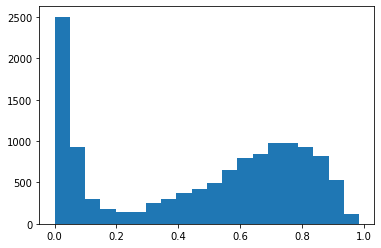

In [16]:
# plotting histogram of predicted probabilities
plt.hist(y_pred_prob, bins=20);

### Save the Predicted Probabilities

Next we'll do is to save the predicted probabilities to s3 so that we can easily use them for potential post hoc analysis

In [17]:
# storing results in a dataframe
df_pred_prob = pd.DataFrame({'y_pred_prob': y_pred_prob})

In [18]:
# save df to csv 
df_pred_prob.to_csv(os.path.join(data_dir, 'y_pred_prob_model_1.csv'), header=True, index=False)

In [19]:
# save csv to s3
y_pred_prob_model_1_location = session.upload_data(os.path.join(data_dir, 'y_pred_prob_model_1.csv'), bucket = bucket, key_prefix=prefix)

### Delete Endpoint

In [20]:
sagemaker.Session().delete_endpoint(linear_predictor.endpoint_name)
print(f"deleted {linear_predictor.endpoint_name} successfully!")

deleted linear-learner-2021-03-03-09-18-06-418 successfully!
